Decided to unwrap Pytorch from the Lightning wrapper but following the same flow beside this making use of Pytorch Dataset and nn.Module classes with the same Optimizer/lr/scheduler model architecture Input ->BERT -> LINEAR -> SIGMOID

In [5]:
%%capture
! pip install transformers
! pip install pytorch-lightning

In [6]:
# Data manipulation Libraries
import pandas as pd
import numpy as np
import re

# data visualization libraries
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tqdm
# set some visual params 
rcParams['figure.figsize'] = 15, 5
pd.set_option('display.max_colwidth', 300)



# Neural network 
import torch
import torch.nn as nn
import pytorch_lightning as pl 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

In [7]:
# Check GPU specs
! nvidia-smi

Mon May  3 18:34:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Investigating Text Data
- Comment length
- Cleaning text data

In [8]:
# Load ToxicDB dataset
toxic_df = pd.read_csv('/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_HappyDB/ToxicComments/toxic_db.csv')
toxic_df = toxic_df.iloc[:, 1:]
toxic_df.rename(columns={'comment_text':'text'}, inplace=True)
# toxic_df
toxic_cols = list(toxic_df.iloc[:, 1:].columns)
toxic_cols

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [9]:
# Filtering clean and toxic subsets
train_clean = toxic_df[toxic_df[toxic_cols].sum(axis=1) < 1]
train_toxic = toxic_df[toxic_df[toxic_cols].sum(axis=1) > 0]

In [10]:
# Balancing out the the dataset by increasing some single and multilabel classes 
obscene_insult = train_toxic[(train_toxic['insult'] == 1) & (train_toxic['obscene'] == 1) & (train_toxic['toxic'] == 0) \
                           & (train_toxic['identity_hate'] == 0) & (train_toxic['threat'] == 0)& (train_toxic['severe_toxic'] == 0)]


# threat_subset = df.loc[df.sum(axis='threat').eq(1)]
threat_subset = train_toxic[(train_toxic['threat'] == 1) & (train_toxic['obscene'] == 0) & (train_toxic['insult'] == 0)]

# hate_subset = df.loc[df.sum(axis='hate').eq(1)]
hate_subset = train_toxic[(train_toxic['identity_hate'] == 1) & (train_toxic['insult'] == 0) & (train_toxic['obscene'] == 0)]

severe = train_toxic[(train_toxic['toxic'] == 1) & (train_toxic['severe_toxic'] == 1) & (train_toxic['obscene'] == 0) & (train_toxic['insult'] == 0)]


print('obscene subset length:', len( obscene_insult),'\n',
      'threat subset length:', len(threat_subset),'\n', 
      'hate subset length:', len(hate_subset),'\n',
      'severe subset length:', len(severe))

obscene subset length: 181 
 threat subset length: 154 
 hate subset length: 201 
 severe subset length: 56


In [11]:
# Oversampling single and multilabel instances of minority classes 
threat_multi = threat_subset.sample(frac=40, replace=True)
hate_multi = hate_subset.sample(frac=30, replace=True)
severe_multi = severe.sample(frac=105, replace=True)
balanced_toxic = pd.concat([threat_multi, hate_multi, obscene_insult, severe_multi, train_toxic])

print('Toxic DF length', len(balanced_toxic))

Toxic DF length 34476


In [12]:
# Quick label count
counts = {}

for col in toxic_cols:
  counts[col] = np.sum(balanced_toxic[col])
counts

{'identity_hate': 8160,
 'insult': 8058,
 'obscene': 8630,
 'severe_toxic': 8078,
 'threat': 8103,
 'toxic': 30823}

# Loading the HappyDB

In [13]:
# Load HappyDB dataset
happy_df = pd.read_csv('/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_HappyDB/HappyDB Classification/cleaned_hm.csv')
happy_df = happy_df[['cleaned_hm','ground_truth_category']]
happy_df = happy_df[happy_df['ground_truth_category'].notnull()].reset_index(drop=True)
happy_df.rename(columns={'cleaned_hm':'text'}, inplace=True)



print(happy_df.shape)
happy_df.head()

(14125, 2)


,text,ground_truth_category
0,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,bonding
1,I meditated last night.,leisure
2,My grandmother start to walk from the bed after a long time.,affection
3,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,bonding
4,when i received flowers from my best friend,bonding


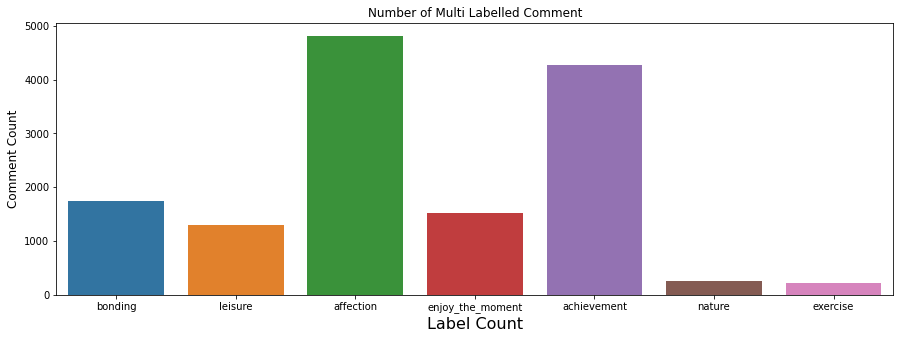

In [14]:
# Plotting multilabelled entries
sns.countplot(x=happy_df['ground_truth_category'])
plt.xlabel("Label Count", fontsize=16)
plt.ylabel("Comment Count",fontsize=12)
plt.title("Number of Multi Labelled Comment",fontsize=12)
plt.show()

In [15]:
dummies = pd.get_dummies(happy_df['ground_truth_category'])
happy_df.drop('ground_truth_category',axis=1, inplace=True)
happy_df = pd.concat([happy_df, dummies], axis=1)
happy_df.head()

,text,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature
0,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,0,0,1,0,0,0,0
1,I meditated last night.,0,0,0,0,0,1,0
2,My grandmother start to walk from the bed after a long time.,0,1,0,0,0,0,0
3,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,0,0,1,0,0,0,0
4,when i received flowers from my best friend,0,0,1,0,0,0,0


In [16]:
achievement = happy_df.loc[happy_df['achievement'].eq(1)]
affection = happy_df.loc[happy_df['affection'].eq(1)]
bonding = happy_df.loc[happy_df['bonding'].eq(1)]
enjoy_the_moment = happy_df.loc[happy_df['enjoy_the_moment'].eq(1)]
exercise = happy_df.loc[happy_df['exercise'].eq(1)]
leisure = happy_df.loc[happy_df['leisure'].eq(1)]
nature = happy_df.loc[happy_df['nature'].eq(1)]

print('achievement Rows', len(achievement))
print('affection Rows', len(affection))
print('bonding Rows', len(bonding))
print('enjoy the moment Rows', len(enjoy_the_moment))
print('exercise Rows', len(exercise))
print('leisure Rows', len(leisure))
print('nature Rows', len(nature))

achievement Rows 4276
affection Rows 4810
bonding Rows 1750
enjoy the moment Rows 1514
exercise Rows 217
leisure Rows 1306
nature Rows 252


In [17]:
achievement = achievement.sample(frac=1.18, replace=True)
affection = affection.sample(frac=1.04, replace=True)
bonding = bonding.sample(frac=2.88, replace=True)
enjoy_the_moment = enjoy_the_moment.sample(frac=3.31, replace=True)
exercise = exercise.sample(frac=23.1, replace=True)
leisure = leisure.sample(frac=3.85, replace=True)
nature = nature.sample(frac=20, replace=True)

balanced_happy = pd.concat([achievement, affection, bonding, enjoy_the_moment, exercise, leisure, nature]).reset_index(drop=True)
balanced_happy = balanced_happy.sample(frac=1)
cols = list(balanced_happy.columns)
balanced_happy.shape

(35180, 8)

In [18]:
cols = list(balanced_happy.iloc[:, 2:].columns)  
counts = {}
for col in cols:
  counts[col] = np.sum(balanced_happy[col])

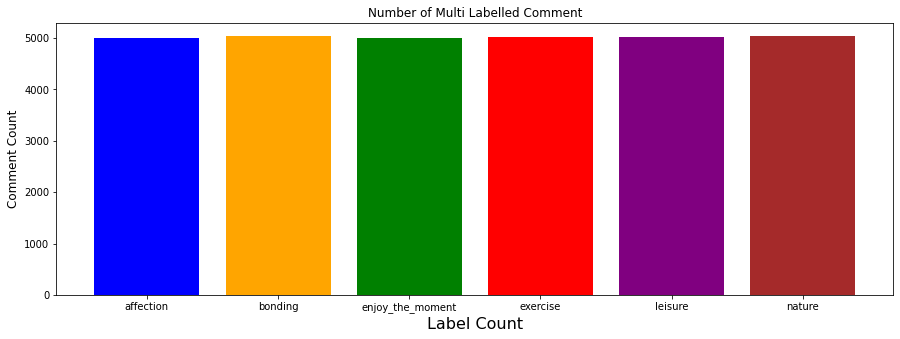

In [19]:
plt.bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink'])
plt.xlabel("Label Count", fontsize=16)
plt.ylabel("Comment Count",fontsize=12)
plt.title("Number of Multi Labelled Comment",fontsize=12)
plt.show()

In [20]:
balanced_happy.shape, balanced_toxic.shape

((35180, 8), (34476, 7))

In [21]:
cols.insert(0, 'text')
balanced_df = balanced_toxic.append(balanced_happy)
balanced_df = balanced_df[cols].sample(frac=1).reset_index(drop=True)

balanced_df.iloc[:,1:] = balanced_df.iloc[:,1:].fillna(0).astype(int)


balanced_df.head()

,text,affection,bonding,enjoy_the_moment,exercise,leisure,nature
0,"It was nice weather a couple weekends ago, so I was able to sit outside, relax, and read a book uninterrupted.",0,0,0,0,0,1
1,Yesterday i attended my friends marriage function and i was very happy to see all of my old friends.,0,1,0,0,0,0
2,"I made it home safely and despite some lousy weather, the drive home was swift and uneventful.",0,0,0,0,0,1
3,I had a nice dinner with a group of graduating students.,0,1,0,0,0,0
4,I cooked my favorite meal for lunch.,0,0,0,0,1,0


In [22]:
all_cols = list(balanced_df.iloc[:,1:].columns)
counts = {}
for col in all_cols:
  counts[col] = np.sum(balanced_df[col])
counts

{'affection': 5002,
 'bonding': 5040,
 'enjoy_the_moment': 5011,
 'exercise': 5013,
 'leisure': 5028,
 'nature': 5040}

# Cleaning the text data

In [23]:
# Cleaning text data
# example of patterns found
# df[df['cleaned_hm'].str.contains('http')]
# df[df['cleaned_hm'].str.contains('@')]
# df[df['cleaned_hm'].str.contains('#')]



# EMOJIS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
#           ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
#           ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
#           ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
#           '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
#           '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
#           ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

URLPATTERN = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)|http" 

SEQPATTERN = r"(.)\1\1+"

SEQREPLACE = r"\1\1"

special_chars = ['"', ':', ';', "_", "#", '@', "~", "|", '{', '}', "*", ">", "<", '\n', '[', ']', '{', '}', '-']

In [24]:
def preprocess_text(text):
  text = re.sub(URLPATTERN, 'address', text)
  for char in special_chars:
    text = text.replace(char, " ")
  text = re.sub(SEQPATTERN, SEQREPLACE, text)
  text = text.lower()

  return text

In [25]:
balanced_df['text'] = balanced_df['text'].apply(preprocess_text)

In [26]:
# df[df['cleaned_hm'].str.contains('https')]
# df[df['cleaned_hm'].str.contains('@')]
# df[df['cleaned_hm'].str.contains('#')]
# df[df['cleaned_hm'].str.contains(':-\)')]

# Check the length of the text 

In [27]:
# Load the bert model for tokenizing and training
%%capture
bert_model_name = 'bert-base-cased'

bert = BertModel.from_pretrained(bert_model_name, return_dict=True)

tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [28]:
# Get the lengths of each comment
lens = [len(x.split()) for x in df['cleaned_hm'].tolist()]

# Better to do this with the tokenizer as its reflective of the how it will split the tokens
lens = []
for sen in balanced_df['text'].tolist():

  encoded_sent = tokenizer.encode(
      sen,
      max_length = 512,
      truncation=True,
      add_special_tokens=True,

  )

  lens.append(len(encoded_sent))

SyntaxError: ignored

In [ ]:
# # Plot length distribution
# sns.displot(lens,height=5, aspect=2.5)
# plt.xlabel("Comment Length")
# plt.ylabel("Comment Count")
# plt.title("Distribution of Comment Length")
# plt.show()

# Splitting The Data Train, Val, Test

In [ ]:
# Split the data
train_df, tmp_df = train_test_split(balanced_df, test_size=0.25, random_state=32)
test_df, val_df = train_test_split(tmp_df, test_size=0.5, random_state=32) 
train_df.shape, val_df.shape, test_df.shape

# Creating Dataset Encoder Class

In [ ]:
# Pytorch dataset encoding class
class CommentsDataset(Dataset):
  # Define the class variables and set the attributes
  def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int=256):
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  # returns length of dataset (standard for pytorch dataset encoder)
  def __len__(self):
    return len(self.data)

  # Indexer function (statndard pytorch dataset encoder)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    # Comment text 
    text = data_row.text
    # Label cols
    labels = data_row[all_cols]

    # Bert encode_plus
    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Return dictionary of relevant model inputs (plus text, labels)
    return dict(
        text=text,
        # Flatten outputs from 2D tensor to 1D
        input_ids=encoding['input_ids'].flatten(),
        attention_mask=encoding['attention_mask'].flatten(),
        labels=torch.FloatTensor(labels)
    )



In [ ]:
# # Test Encoding class
# train_dataset = CommentsDataset(train_df, tokenizer)
# # Print index zero comment text, labels, input_id shape (tensor len(256))
# sample_item = train_dataset[0]
# print(sample_item.keys(), '\n')
# print(sample_item['text'], '\n')
# print(sample_item['labels'], '\n')
# # Padded / Truncated and flattened Comment to 1D tensor of len 256
# print(sample_item['input_ids'].shape)

# Encoded dataset and fitting DataLoaders

In [ ]:
TOKEN_LEN = 256
BATCH_SIZE = 32

train_dataset = CommentsDataset(train_df, tokenizer, max_token_len=TOKEN_LEN) 
val_dataset = CommentsDataset(val_df, tokenizer, max_token_len=TOKEN_LEN) 
test_dataset = CommentsDataset(test_df, tokenizer, max_token_len=TOKEN_LEN) 


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)  

len(train_dataloader), len(val_dataloader)

In [ ]:
# check if cuda is available
# train_on_gpu = torch.cuda.is_available()

# device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')

# Custom Model Class

In [ ]:
# Pytorch nn.Module Model Class
%%capture
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased", return_dict=False)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, 6)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, attention_mask)
        output = self.classifier(pooled_output)
        output = torch.sigmoid(output)
        return output    
                    
                    
                    
model = SentimentClassifier(n_classes=6)

model.to(device)

In [ ]:
##### Test model class #####
# data = next(iter(train_dataloader))
# data.keys()

# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)
# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length
# model(input_ids, attention_mask)

# Define Loss Function, Optimizer, Scheduler, and Custom Accuracy Function

In [ ]:
epochs = 5


criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=2e-5)


steps_per_epoch = len(train_df) // BATCH_SIZE
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * epochs - warmup_steps
scheduler = get_linear_schedule_with_warmup( optimizer, warmup_steps, total_steps)

In [ ]:
##### Function to calcuate the accuracy ##### 
def calcuate_acc(batch_idx, outputs, labels):
    outputs[outputs >= 0.5] = 1
    outputs[outputs < 0.5] = 0 
    N,C = labels.shape
    accuracy = (outputs == labels).sum() / (N*C) * 100
    return accuracy

In [ ]:
epochs=15
###################################################  
################# TRAINING LOOP #################  
###################################################
def train_val(epoch):    
    tr_loss = 0
    n_correct = 0
    tr_loss_history = []
    model.train()
    print(f'============= EPOCH {epoch+1} =============\n') 
    for batch_idx, data in enumerate(train_dataloader):
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(ids, mask)
        if labels is not None:
          loss = criterion(outputs, labels)
        loss.backward()
        tr_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

        accuracy = calcuate_acc(batch_idx, outputs, labels)
        n_correct+=accuracy
        
        if batch_idx % 480 == 0 and batch_idx != 0:
            loss_step = tr_loss/batch_idx
            acc_step = n_correct/batch_idx
            print(f"Training Loss Over {batch_idx} steps: {loss_step:.2f}")
            print(f"Training Accuracy Over {batch_idx} steps: {acc_step:.2f}\n")
    epoch_loss = tr_loss/batch_idx
    epoch_acc = n_correct/batch_idx
    print(f"Training Loss Epoch: {epoch_loss:.2f}")
    print(f"Training Accuracy Epoch: {epoch_acc:.2f}\n")
    tr_loss_history.append(epoch_loss)

###################################################  
################# VALIDATION LOOP #################  
###################################################
    val_loss_min = np.inf
    val_loss = 0
    n_correct = 0
    val_loss_history = []
    with torch.no_grad():
      for batch_idx, data in enumerate(val_dataloader):
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(ids, mask)

        loss=0
        if labels is not None:
          loss = criterion(outputs, labels)
        val_loss += loss.item()

        accuracy = calcuate_acc(batch_idx, outputs, labels)
        n_correct+=accuracy
        
        if batch_idx % 2000 == 0 and batch_idx != 0:
            loss_step = val_loss/batch_idx
            acc_step = n_correct/batch_idx
            print(f"Validation Loss Over {batch_idx} steps: {loss_step:.2f}")
            print(f"Validation Accuracy Over {batch_idx} steps: {acc_step:.2f}\n")
      epoch_loss = val_loss/batch_idx
      epoch_acc = n_correct/batch_idx
      print(f"Validation Loss Epoch: {epoch_loss:.2f}")
      print(f"Validation Accuracy Epoch: {epoch_acc:.2f}\n")
      val_loss_history.append(epoch_loss)
      


      # Checpoininting the model using val loss threshold
      if epoch_loss <= val_loss_min:
        print("Epoch Val Loss Decreased... Saving model")
        # save current model
        torch.save(model.state_dict(), '/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_HappyDB/V2_model_state.pt')
        val_loss_min = epoch_loss
      # Step the scheduler for the next epoch
      scheduler.step()
      # Print the updated learning rate
      print('Learning Rate Set To: {:.10f}'.format(optimizer.state_dict()['param_groups'][0]['lr']),'\n')
      print('============= EPOCH END =============\n') 

      return tr_loss_history, val_loss_history

In [ ]:
for epoch in range(epochs):
  train_val(epoch)

============= EPOCH 1 =============



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Loss Over 480 steps: 0.09
Training Accuracy Over 480 steps: 97.80

Training Loss Over 960 steps: 0.09
Training Accuracy Over 960 steps: 97.76

Training Loss Over 1440 steps: 0.09
Training Accuracy Over 1440 steps: 97.78

Training Loss Epoch: 0.09
Training Accuracy Epoch: 97.80

Validation Loss Over 2000 steps: 0.08
Validation Accuracy Over 2000 steps: 97.96

Validation Loss Over 4000 steps: 0.08
Validation Accuracy Over 4000 steps: 98.03

Validation Loss Over 6000 steps: 0.08
Validation Accuracy Over 6000 steps: 97.91

Validation Loss Over 8000 steps: 0.08
Validation Accuracy Over 8000 steps: 97.88

Validation Loss Epoch: 0.08
Validation Accuracy Epoch: 97.90

Epoch Val Loss Decreased... Saving model
Learning Rate Set To: 0.0000004412 

============= EPOCH END =============

============= EPOCH 2 =============

Training Loss Over 480 steps: 0.08
Training Accuracy Over 480 steps: 98.17

Training Loss Over 960 steps: 0.08
Training Accuracy Over 960 steps: 98.16

Training Loss Ov

In [3]:
# Plot the average epoch losses 
import matplotlib.pyplot as plt
plt.plot(tr_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

# Inference On Sample Sentences

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_HappyDB/V2_model_state.pt'))
model.eval()
model.cuda()

In [ ]:
def classify_data(data):
  id_list = []
  mask_list = []
  preds = []

  for x in data:
    encoding = tokenizer.encode_plus(
      x,
      add_special_tokens=True,
      max_length=256,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt')
    
    id_list.append(encoding['input_ids'].to(device))
    mask_list.append(encoding['attention_mask'].to(device))
  
  i = 0
  while i < len(data):
    output = model(id_list[i], mask_list[i])


    test_prediction = output.detach().cpu().numpy().flatten()
    preds.append(test_prediction.tolist())
    i+=1

  preds_df = pd.DataFrame(np.round(preds,2), columns=[all_cols])
  return preds_df

  

In [ ]:
classify_data(["I did well in a test", "I love you you are the best", 'im happy with how it turned out', 'my friend and I are friends'])

The oversampling by straight duplicating existing rows failed to deliver promising results as the data is also very limited certain words such as friend triggers bonding and happy triggers enjoy the moment

A synthetic sampling technuique may imporve but ideally more variation of data by collecting and combining datasets should prove the best results.